In [ ]:
!pip install torchmetrics
!pip install torchnet

In [ ]:
# ML and other imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gc
import random
from PIL import Image
from IPython.display import clear_output

In [3]:
# PyTorch imports
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torchnet as tnt
import torch.nn.functional as F
from torchmetrics import Accuracy

In [ ]:
# Retreive the Apple2Orange dataset
!wget https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true

In [ ]:
!mkdir datasets
!bash ./download_cyclegan_dataset.sh?raw=true apple2orange

In [ ]:
# Helper Functions
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

### 1) Dataset creation

In [ ]:
# Class to load the images and apply transformations

class GeneratorDataset(data.Dataset):

    def __init__(self, root_dir, transform=None):
      
      self.root_dir = root_dir
      self.transform = transform
      self.image_path = sorted(os.listdir(root_dir))
      self.filenames = np.array(self.image_path)


    def __len__(self):
      return len(self.image_path) # no. of images in the dataset

    def __getitem__(self, idx):

      # Convert the image to RGB
      img_path = os.path.join(self.root_dir, self.image_path[idx])
      image = Image.open(img_path).convert('RGB')
      # Apply the transformation (if specified)
      if self.transform:
        image = self.transform(image)

      return image


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = 'apple2orange'
DATASET_PATH = os.path.join("datasets", DATASET) # Dataset path
OUTPUT_PATH = 'outputs'
base_logdir = os.path.join("logs", 'pytorch') # Sets up a log directory.
RESIZE_SHAPE = 128 # Resized image size for faster training

In [ ]:
# Create the dataset objects
preprocess_train_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

preprocess_test_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainA"),
                           transform=preprocess_train_transformations)

train_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainB"),
                           transform=preprocess_train_transformations)

test_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testA"),
                           transform=preprocess_test_transformations)

test_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testB"),
                           transform=preprocess_test_transformations)

print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 995 images in trainA
Found 1019 images in trainB
Found 266 images in testA
Found 248 images in testB


In [ ]:
# Use a subset of the training data for efficiency purposes

random.seed(2)

N_IMAGES_TO_SAMPLE = 400

indices_X = random.sample(range(len(train_data_X)), N_IMAGES_TO_SAMPLE)
indices_Y = random.sample(range(len(train_data_Y)), N_IMAGES_TO_SAMPLE)

train_data_X = Subset(train_data_X, indices_X)
train_data_Y = Subset(train_data_Y, indices_Y)

### 2) Generator and Discriminator Models

In [11]:
##############################
#           RESNET
##############################

class ResidualBlock(nn.Module):
    def __init__(self, in_features):

      # ****START CODE****
      super(ResidualBlock, self).__init__()
      self.block = nn.Sequential(
          # Convolutional block 1: capture important features from the i/p
          nn.ReflectionPad2d(1),
          nn.Conv2d(in_features, in_features, kernel_size=3, stride = 1, padding=0),
          nn.InstanceNorm2d(in_features),
          nn.ReLU(inplace=True),
          nn.ReflectionPad2d(1),
          # Conv block 2: learn residual information
          nn.Conv2d(in_features, in_features, kernel_size=3, stride = 1, padding=0),
          nn.InstanceNorm2d(in_features),
          nn.Dropout(0.2)
      )
      # ****END CODE****

    def forward(self, x):

      # ****START CODE****
      return x + self.block(x)
      # ****END CODE****


class GeneratorResNet(nn.Module):
    def __init__(self, input_channel, n_blocks, filters, output_channel):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(input_channel),
            nn.Conv2d(input_channel, filters, 7),
            nn.InstanceNorm2d(filters),
            nn.ReLU(inplace=True),
        ]
        in_features = filters

        # Downsampling
        for _ in range(2):
            filters *= 2
            model += [
                nn.Conv2d(in_features, filters, 3, stride=2, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResidualBlock(filters)]

        # Upsampling
        for _ in range(2):
            filters //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, filters, 3, stride=1, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Output layer
        model += [nn.ReflectionPad2d(output_channel), nn.Conv2d(filters, output_channel, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_channel, filters):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channel, filters, normalize=False),
            *discriminator_block(filters, filters * 2),
            *discriminator_block(filters * 2, filters * 4),
            *discriminator_block(filters * 4, filters *8),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(filters *8, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [12]:
# Initialize the Generators and Discriminaotrs

G_YtoX = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
G_XtoY = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
Dx = Discriminator(input_channel=3, filters=64).to(device)
Dy = Discriminator(input_channel=3, filters=64).to(device)

In [13]:
# Initialize layer weights

def weights_init_normal(m):

  if isinstance(m, nn.Conv2d):
    nn.init.normal_(m.weight.data, 0.0, 0.2) # Weights initialized with Normal distribution
    if m.bias is not None:
      nn.init.constant_(m.bias.data, 0.0) # Bias set to zero
  if isinstance(m, nn.InstanceNorm2d):
      if hasattr(m, 'weight') and m.weight is not None:
        nn.init.normal_(m.weight.data, mean = 1.0, std = 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant_(m.bias.data, 0.0)


In [ ]:
# Initialize the values of the two generators

# ****START CODE****
G_XtoY.apply(weights_init_normal)
G_YtoX.apply(weights_init_normal)
# ****END CODE****

# Initialize the values of the two discriminators

# ****START CODE****
Dx.apply(weights_init_normal)
Dy.apply(weights_init_normal)
# ****END CODE****

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### 3) Training

In [9]:
# Hyperparameters
BATCH_SIZE = 10
EPOCHs = 30
SAVE_EVERY_N_EPOCH = 5
LR = 0.0002
BETAS = (0.5, 0.999)

In [ ]:
# Dataloaders for the train and test set
train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=BATCH_SIZE,
                                                    shuffle=True, num_workers=0)
train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

In [ ]:
# Load Sample Images (to check progress during training)
id_sample_X = np.where(test_data_X.filenames == "n07740461_10011.jpg")[0][0]
id_sample_Y = np.where(test_data_Y.filenames == "n07749192_10081.jpg")[0][0]
sample_X = test_data_X[id_sample_X]
sample_Y = test_data_Y[id_sample_Y]

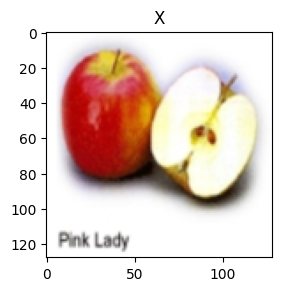

In [ ]:
plt.subplot(121)
plt.title('X')
plt.imshow(deprocess(sample_X))

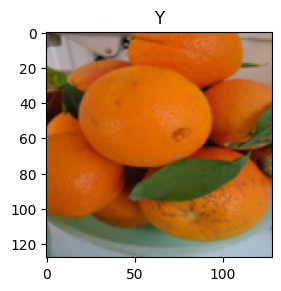

In [ ]:
plt.subplot(121)
plt.title('Y')
plt.imshow(deprocess(sample_Y))

In [ ]:
# Define Optmizers

Dx_optimizer = optim.Adam(Dx.parameters(), lr=LR, betas=BETAS)
Dy_optimizer = optim.Adam(Dy.parameters(), lr=LR, betas=BETAS)
G_XtoY_optimizer = optim.Adam(G_XtoY.parameters(), lr=LR, betas=BETAS)
G_YtoX_optimizer = optim.Adam(G_YtoX.parameters(), lr=LR, betas=BETAS)

# Function to update the learning rate decay for the schedulers
lambda_lr_func = lambda epoch: 1.0 - max(0, epoch - (EPOCHs/2)) / (EPOCHs - (EPOCHs/2)) # Start decaying the epoch after half of the planned epochs

# Define Schedulers

scheduler_Dy = lr_scheduler.LambdaLR(Dy_optimizer, lr_lambda = lambda_lr_func)
scheduler_Dx = lr_scheduler.LambdaLR(Dx_optimizer, lr_lambda = lambda_lr_func)
scheduler_G_XtoY = lr_scheduler.LambdaLR(G_XtoY_optimizer, lr_lambda = lambda_lr_func)
scheduler_G_YtoX = lr_scheduler.LambdaLR(G_YtoX_optimizer, lr_lambda = lambda_lr_func)

#### Loss Functions

In [17]:
SOFT_FAKE_LABEL_RANGE =  [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.

#We use ranges for the label instead of a hard 1/0 to stabilize the training process, smoothen the gradients and avoiding mode collapse

# Function to scale a tensor within the label range (called below to generate the real/fake label tensors r1 and r2)
def scale_tensor(tensor, range_list):

    x, y = range_list
    scaled_tensor = x + (tensor * (y - x))

    return scaled_tensor

In [18]:
def discriminator_loss(loss_type, real_image = None, generated_image = None):
  '''
  loss_type : "real" or "fake" (based on the image type being passed to the discriminator)
  '''
  # If we pass a real image (to minimize loss between the discriminator's prediction and real labels)
  if loss_type == "real":
    r2 = scale_tensor(torch.rand(real_image.shape, device = real_image.device), SOFT_REAL_LABEL_RANGE) # Real labels, range [0.7,1.2]
    loss = 0.5 * torch.mean((real_image - r2) ** 2) # Real loss

  # If we pass a generated image (to minimize loss between the discriminator's prediction and fake labels)
  elif loss_type == "fake":
    r1 = scale_tensor(torch.rand(generated_image.shape, device = generated_image.device), SOFT_FAKE_LABEL_RANGE) # Fake labels, range [0.0,0.3]
    loss = 0.5 * torch.mean((generated_image - r1) ** 2) # Fake loss

  return loss

def generator_loss(D_predictions):
  '''
  D_predictions : Discriminator response based on a generated/fake image
  '''
  # The generator attempts to "fool" the discriminator
  # (thus minimize loss between discriminator's predictions on a fake image and real labels)
  r2 = scale_tensor(torch.rand(D_predictions.shape, device = D_predictions.device), SOFT_REAL_LABEL_RANGE)
  loss = torch.mean((D_predictions - r2) ** 2)
  return loss

def cycle_consistency_loss(real_image, cycled_image, LAMBDA = 10):

  # Minimize the loss between a real image and the resulting image when it is cycled back
  # (i.e. real image -> fake image via G_XtoY -> attempt to recreate first image via G_YtoX)

  loss = LAMBDA * torch.mean(torch.abs(real_image - cycled_image))
  return loss

def identity_loss(real_image, generated_image, LAMBDA = 10):

  # Minimizes the loss between a real image and the image generated by passing the same real image through the relevant generator

  loss = 0.5 * LAMBDA * torch.mean(torch.abs(real_image - generated_image))
  return loss

#### Checkpoint and Other Functions

In [22]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', DATASET, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    #'G_optimizer' : G_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    #G_optimizer.load_state_dict(checkpoint['G_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [23]:
def generate_images(model, test_input):
  # ****START CODE****
  return model(test_input.to(device))
  # ****END CODE****

#### Training

In [24]:
# Model Training

import time

def training_loop(train_image_loader_X, train_image_loader_Y, EPOCHs, G_XtoY, G_YtoX, Dx, Dy,
                  G_XtoY_optimizer, G_YtoX_optimizer, Dx_optimizer, Dy_optimizer,
                  scheduler_Dx, scheduler_Dy, scheduler_G_XtoY, scheduler_G_YtoX,
                  device):

  training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / BATCH_SIZE)).astype(int)

  # To track training progress

  to_track =["Epochs", "Total_time", "Dx_losses", "Dy_losses", "G_XtoY_losses", "G_YtoX_losses"]
  total_train_time = 0
  results = {}
  for item in to_track:
      results[item] = []

  for epoch in range(1, EPOCHs + 1):
      start = time.time()
      print('Start of epoch %d' % (epoch,))

      # Reset dataloader
      iter_train_image_X = iter(train_image_loader_X)
      iter_train_image_Y = iter(train_image_loader_Y)
      # Initialize losses
      G_XtoY_loss_mean = 0
      G_YtoX_loss_mean = 0
      Dx_loss_mean = 0
      Dy_loss_mean = 0

      for step in range(training_steps):

          real_image_X = next(iter_train_image_X).to(device)
          real_image_Y = next(iter_train_image_Y).to(device)

          # ============================
          # Train the Discriminators
          # ============================

          # 1. Generate fake X & Y images
          fake_image_X = generate_images(G_YtoX, real_image_Y)
          fake_image_Y = generate_images(G_XtoY, real_image_X)

          # 2. Get Discriminator responses on real and fake images
          Dx_real_output = Dx(real_image_X)
          Dx_fake_output = Dx(fake_image_X.detach())
          Dy_real_output = Dy(real_image_Y)
          Dy_fake_output = Dy(fake_image_Y.detach())

          # 3. Compute discriminator losses
          Dx_real_loss = discriminator_loss(loss_type= "real", real_image = Dx_real_output)
          Dx_fake_loss = discriminator_loss(loss_type= "fake", generated_image = Dx_fake_output)
          Dy_real_loss = discriminator_loss(loss_type= "real", real_image = Dy_real_output)
          Dy_fake_loss = discriminator_loss(loss_type= "fake", generated_image = Dy_fake_output)
          Dx_loss = Dx_real_loss + Dx_fake_loss
          Dy_loss = Dy_real_loss + Dy_fake_loss

          # 4. Reset gradients
          Dx_optimizer.zero_grad()
          Dy_optimizer.zero_grad()

          # 5. Backpropogation
          Dx_loss.backward(retain_graph = True)
          Dy_loss.backward(retain_graph = True)

          # 6. Optimizer step
          Dx_optimizer.step()
          Dy_optimizer.step()

          Dx_loss_mean += Dx_loss.item()
          Dy_loss_mean += Dy_loss.item()

          # ============================
          # Train the Generators
          # ============================

          # 1. Generate fake X & Y Images
          fake_image_X = generate_images(G_YtoX, real_image_Y)
          fake_image_Y = generate_images(G_XtoY, real_image_X)

          # 2. Compute generator loss based on discriminator response to the fake images
          Dy_response = Dy(fake_image_Y)
          Dx_response = Dx(fake_image_X)
          G_XtoY_loss = generator_loss(Dy_response)
          G_YtoX_loss = generator_loss(Dx_response)

          # 3. Reconstruct images and compute the cycle consistency loss
          reconstructed_image_X = generate_images(G_YtoX, fake_image_Y)
          reconstructed_image_Y = generate_images(G_XtoY, fake_image_X)

          cycle_X_loss = cycle_consistency_loss(real_image_X, reconstructed_image_X)
          cycle_Y_loss = cycle_consistency_loss(real_image_Y, reconstructed_image_Y)

          # 4. Generate identity images and compute the identity loss
          regenerated_image_Y = generate_images(G_XtoY, real_image_Y)
          regenerated_image_X = generate_images(G_YtoX, real_image_X)
          identity_Y_loss = identity_loss(real_image_Y, regenerated_image_Y)
          identity_X_loss = identity_loss(real_image_X, regenerated_image_X)

          # 5. Total generator losses
          G_XtoY_loss = G_XtoY_loss + cycle_X_loss + identity_X_loss
          G_YtoX_loss = G_YtoX_loss + cycle_Y_loss + identity_Y_loss

          # 6. Reset gradients to a clean state
          G_XtoY_optimizer.zero_grad()
          G_YtoX_optimizer.zero_grad()

          # 7. Backpropogation
          G_XtoY_loss.backward()
          G_YtoX_loss.backward()

          # 8. Optimizer step
          G_XtoY_optimizer.step()
          G_YtoX_optimizer.step()

          G_XtoY_loss_mean += G_XtoY_loss.item()
          G_YtoX_loss_mean += G_YtoX_loss.item()

          if step % 10 == 0:
            print ('.', end='')

      clear_output(wait=True)

      end = time.time()
      total_train_time += (end-start)

      # ============================
      # Update the learning rate after each epoch
      # ============================
      scheduler_G_XtoY.step()
      scheduler_G_YtoX.step()
      scheduler_Dx.step()
      scheduler_Dy.step()

      # ============================
      # Print and store loss values at the end of an epoch
      # ============================

      print("Epoch {epoch}/{EPOCHs} ",
        f"G_XtoY Loss: {G_XtoY_loss_mean/training_steps:.4f}, "
        f"G_YtoX Loss: {G_YtoX_loss_mean/training_steps:.4f}, "
        f"Dx Loss: {Dx_loss_mean/training_steps:.4f}, "
        f"Dy Loss: {Dy_loss_mean/training_steps:.4f}")

      results["Epochs"].append(epoch)
      results["Total_time"].append(total_train_time)
      results["Dx_losses"].append(Dx_loss_mean)
      results["Dy_losses"].append(Dy_loss_mean)
      results["G_XtoY_losses"].append(G_XtoY_loss_mean)
      results["G_YtoX_losses"].append(G_YtoX_loss_mean)


      # ============================
      # Using consistent images (sample_X and sample_Y), plot the progress of the training using both generators
      # ============================
      generated_Y = generate_images(G_XtoY, sample_X.unsqueeze(0))
      generated_X = generate_images(G_YtoX, sample_Y.unsqueeze(0))

      # Visualization
      fig, axs = plt.subplots(2, 2, figsize=(10, 10))
      axs[0, 0].imshow((sample_X.permute(1, 2, 0).cpu().numpy() + 1) / 2)
      axs[0, 0].set_title("Input X")
      axs[0, 1].imshow((generated_Y.squeeze(0).detach().permute(1,2,0).cpu().numpy() + 1) / 2)
      axs[0, 1].set_title("Generated Y")
      axs[1, 0].imshow((sample_Y.permute(1, 2, 0).cpu().numpy() + 1) / 2)
      axs[1, 0].set_title("Input Y")
      axs[1, 1].imshow((generated_X.squeeze(0).detach().permute(1, 2, 0).cpu().numpy() + 1) / 2)
      axs[1, 1].set_title("Generated X")
      plt.show()

      # ============================
      # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch
      # ============================

      if epoch % SAVE_EVERY_N_EPOCH == 0:
          # ****START CODE****
          save_training_checkpoint(epoch)
          # ****END CODE****
          print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                            checkpoint_path))

      print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                        time.time()-start))
      gc.collect()

  return results

Epoch {epoch}/{EPOCHs}  G_XtoY Loss: 2.2720, G_YtoX Loss: 2.2803, Dx Loss: 0.0795, Dy Loss: 0.0841


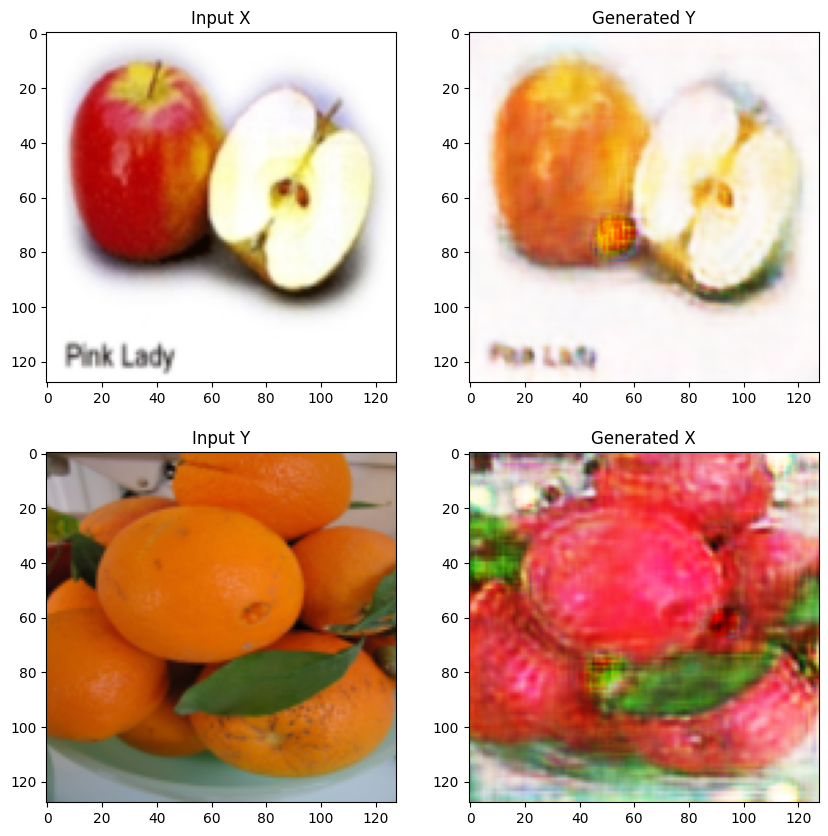

Saving checkpoint for epoch 30 at checkpoints/pytorch/apple2orange
Time taken for epoch 30 is 68.33960056304932 sec



In [ ]:
# Run training
GAN_results = training_loop(train_image_loader_X, train_image_loader_Y, EPOCHs, G_XtoY, G_YtoX, Dx, Dy,
                  G_XtoY_optimizer, G_YtoX_optimizer, Dx_optimizer, Dy_optimizer,
                  scheduler_Dx, scheduler_Dy, scheduler_G_XtoY, scheduler_G_YtoX,
                  device)

# Dataframe to store training results
TrainResults_df =  pd.DataFrame.from_dict(GAN_results)

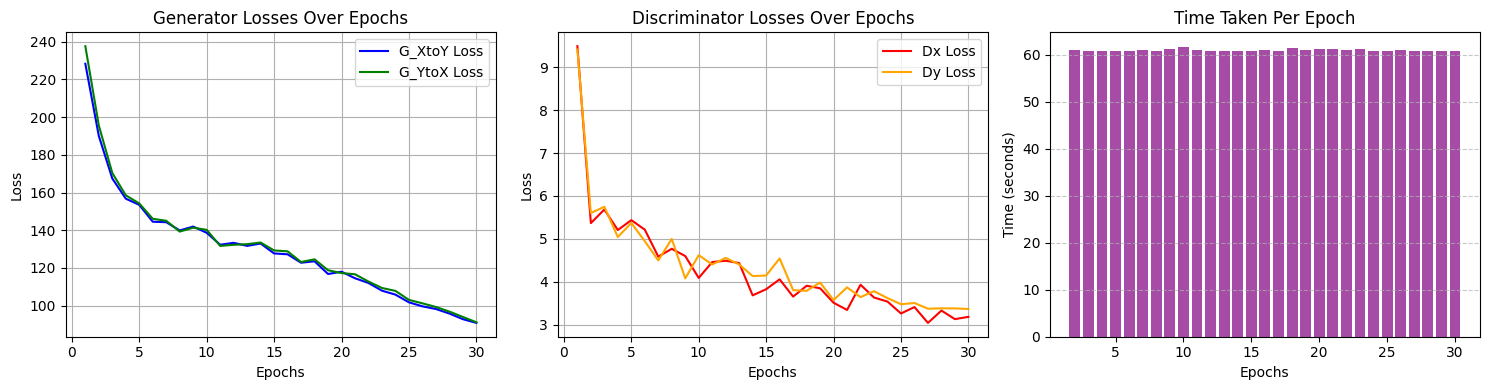

In [ ]:
# Plot CycleGAN Performance

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns, custom figure size

# Plot Generator losses
axes[0].plot(TrainResults_df['Epochs'], TrainResults_df['G_XtoY_losses'], label='G_XtoY Loss', color='blue')
axes[0].plot(TrainResults_df['Epochs'], TrainResults_df['G_YtoX_losses'], label='G_YtoX Loss', color='green')
axes[0].set_title('Generator Losses Over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Discriminator losses
axes[1].plot(TrainResults_df['Epochs'], TrainResults_df['Dx_losses'], label='Dx Loss', color='red')
axes[1].plot(TrainResults_df['Epochs'], TrainResults_df['Dy_losses'], label='Dy Loss', color='orange')
axes[1].set_title('Discriminator Losses Over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Plot Time Taken Per Epoch
TrainResults_df['time_per_epoch'] = TrainResults_df['Total_time'].diff()
axes[2].bar(TrainResults_df['Epochs'], TrainResults_df['time_per_epoch'], color='purple', alpha=0.7)
axes[2].set_title('Time Taken Per Epoch')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Time (seconds)')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()

### 4) Testing

 Domain X ---> Y : Apple to Orange


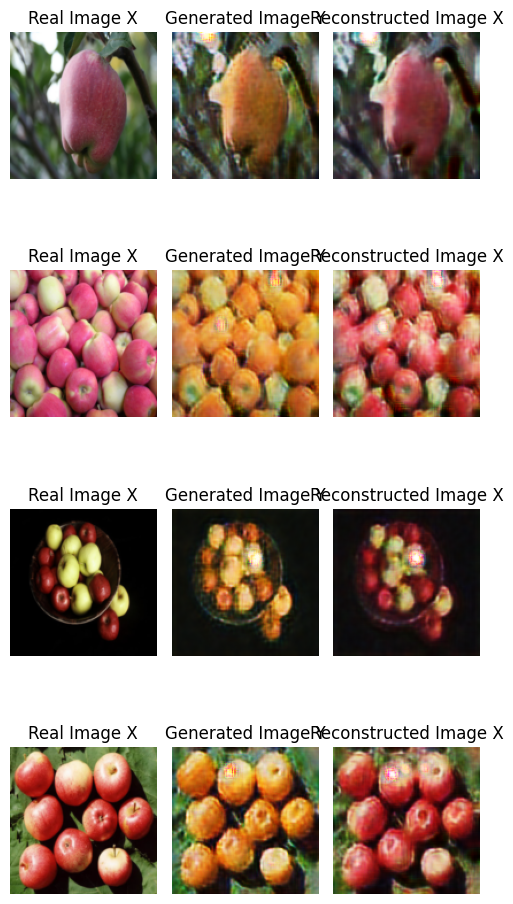

In [ ]:
N_IMAGES_TO_SAMPLE_TEST = 4
print (" Domain X ---> Y : Apple to Orange")

# Sampling 4 images from the test set
indices_X = random.sample(range(len(test_data_X)), N_IMAGES_TO_SAMPLE_TEST)
test_data_X = Subset(test_data_X, indices_X)


# Set up the display grid
fig, axes = plt.subplots(4, 3, figsize=(5, 10))

# Iterate through sampled images from domain X
for i in range(N_IMAGES_TO_SAMPLE_TEST):

  real_image_X = test_data_X[i].to(device)
  generated_image_Y = generate_images(G_XtoY, real_image_X.unsqueeze(0))
  reconstructed_image_X = generate_images(G_YtoX, generated_image_Y)

  # Display real_image_X and fake_image_Y
  axes[i, 0].imshow(deprocess(real_image_X))
  axes[i, 0].set_title('Real Image X')
  axes[i, 0].axis('off')
  axes[i, 1].imshow(deprocess(generated_image_Y.squeeze(0).detach()))
  axes[i, 1].set_title('Generated Image Y')
  axes[i, 1].axis('off')
  axes[i, 2].imshow(deprocess(reconstructed_image_X.squeeze(0).detach()))
  axes[i, 2].set_title('Reconstructed Image X')
  axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

 Domain Y ---> X : Orange to Apple


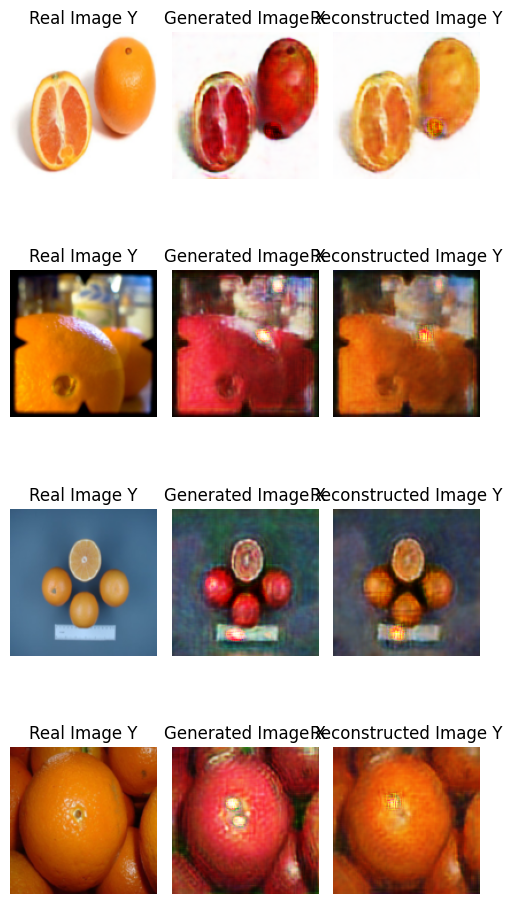

In [ ]:
N_IMAGES_TO_SAMPLE_TEST = 4
print (" Domain Y ---> X : Orange to Apple")

# Sampling 4 images from the test set
indices_Y = random.sample(range(len(test_data_Y)), N_IMAGES_TO_SAMPLE_TEST)
test_data_Y = Subset(test_data_Y, indices_Y)

# Set up the display grid
fig, axes = plt.subplots(4, 3, figsize=(5, 10))

# Iterate through sampled images from domain X
for i in range(N_IMAGES_TO_SAMPLE_TEST):

  real_image_Y = test_data_Y[i].to(device)
  generated_image_X = generate_images(G_YtoX, real_image_Y.unsqueeze(0))
  reconstructed_image_Y = generate_images(G_XtoY, generated_image_X)

  # Display real_image_X and fake_image_Y
  axes[i, 0].imshow(deprocess(real_image_Y))
  axes[i, 0].set_title('Real Image Y')
  axes[i, 0].axis('off')
  axes[i, 1].imshow(deprocess(generated_image_X.squeeze(0).detach()))
  axes[i, 1].set_title('Generated Image X')
  axes[i, 1].axis('off')
  axes[i, 2].imshow(deprocess(reconstructed_image_Y.squeeze(0).detach()))
  axes[i, 2].set_title('Reconstructed Image Y')
  axes[i, 2].axis('off')

plt.tight_layout()
plt.show()